In [1]:
from IPython.display import Image
import graphviz
import json

from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

True

## Code

In [2]:
from dataclasses import dataclass, field,asdict
from typing import List, Tuple, Dict,Optional,Literal

@dataclass
class Member:
    """ 
    This class defines the schema of a member in the environment.

    Args:
        name (str): The name of the member.
        role (str): The role of the member.
        description (str): The description of the member.

    Examples:
        >>> member = Member(name="Alice", role="Manager", description="Alice is the manager of the team.")
        >>> member
        Member(name='Alice', role='Manager', description='Alice is the manager of the team.')

    """
    name: str
    role: str
    description: str

@dataclass
class Env:
    """
    This class defines the schema of the environment including the event description, members, and relationships.

    Args:
        description (str): The description of the environment.
        members (List[Member]): The list of members in the environment.
        relationships (List[Tuple[str,str]]|Dict[str,List[str]]): The relationships between the members. It can be a list of tuples or a dictionary or None. If None, it defaults to members knowing each other in a round-robin fashion.

    Examples:
        ### Case 1: The relationships are defined as a list of tuples.
        >>> members = [Member(name="Alice", role="Manager", description="Alice is the manager of the team."),
        ...            Member(name="Bob", role="Employee", description="Bob is an employee of the team."),
        ...            Member(name="Charlie", role="Employee", description="Charlie is an employee of the team.")]
        >>> relationships = [("Alice", "Bob"), ("Alice", "Charlie")]
        >>> env = Env(description="This is a team of three members.", members=members, relationships=relationships)

        ### Case 2: The relationships are defined as a dictionary.
        >>> members = [Member(name="Alice", role="Manager", description="Alice is the manager of the team."),
        ...            Member(name="Bob", role="Employee", description="Bob is an employee of the team."),
        ...            Member(name="Charlie", role="Employee", description="Charlie is an employee of the team.")]
        >>> relationships = {"Alice": ["Bob", "Charlie"]}
        >>> env = Env(description="This is a team of three members.", members=members, relationships=relationships)
        
    """
    description: str
    members: List[Member] = field(default_factory=list)
    relationships: List[Tuple[str,str]]|Dict[str,List[str]] = None

@dataclass
class Message:
    """ 
    This class defines the schema of a simple message that is exchanged between agents.

    Args:
        sender (str): The sender of the message.
        action (str): The action type of the message.
        result (str): The result of the action.
    """
    sender: str
    action: str
    result: str

@dataclass
class GroupMessageProtocol:
    """
    This class defines the schema of a group message protocol that is used to share messages between agents in a group.

    Args:
        group_id (str): The group id of the group.
        env (Env): The environment settings of the group.
        context (List[Message]): The list of messages exchanged between agents.
        next_agent (str): The next agents to send the message.

    """
    group_id: str
    env: Env
    context: List[Message] = field(default_factory=list)
    next_agent: str = None # currently only one agent is supported

In [3]:
import random
import yaml
import uuid
import itertools
from pydantic import BaseModel

class Group:
    def __init__(self, 
                 env:Env|str,
                 model_client: OpenAI,
                 group_id: str = None,
                 entry_agent: Optional[str] = None):
        self.group_id:str = group_id if group_id else str(uuid.uuid4())
        self.env: Env = self._read_env_from_file(env) if isinstance(env, str) else env
        self.fully_connected = False
        self._rectify_relationships()
        self.model_client: OpenAI = model_client # currently only supports OpenAI synthetic API
        self.current_agent: Optional[str] = entry_agent if entry_agent else random.choice([m.name for m in self.env.members])
        self.members_map: Dict[str, Member] = {m.name: m for m in self.env.members}
        self.next_choice_base_model_map: Dict[str, BaseModel] = self._build_next_choice_base_model_map(incude_current=False)
        self.next_choice_base_model_map_incldue_current: Dict[str, BaseModel] = self._build_next_choice_base_model_map(incude_current=True)
        self.group_messages: GroupMessageProtocol = GroupMessageProtocol(group_id=self.group_id,env=self.env)
        self.member_iterator = itertools.cycle(self.env.members)

    def handoff_one_turn(self,
                         next_speaker_select_mode:Literal["order","auto","auto2","random"]="auto",
                         model:str="gpt-4o-mini",
                         include_current:bool = True) -> str:
        if next_speaker_select_mode == "order":
            next_agent = next(self.member_iterator).name
        elif next_speaker_select_mode == "random":
            next_agent = random.choice([m.name for m in self.env.members])
        elif next_speaker_select_mode == "auto":
            # use function tool to handoff
            handoff_tools = self._build_current_agent_handoff_tools(include_current)

            messages = [{"role": "system", "content":"Decide who should be the next person to talk.Transfer the conversation to the next person."}]
            handoff_message = self._build_handoff_message(self.group_messages,cut_off=3,use_tool=True)
            messages.extend([{"role": "user", "content": handoff_message}])

            response = self.model_client.chat.completions.create(
                        model=model,
                        messages=messages,
                        temperature = 0.0,
                        tools=handoff_tools,
                        tool_choice="required"
                    )
            next_agent = response.choices[0].message.tool_calls[0].function.name
        
        elif next_speaker_select_mode == "auto2":
            # use response_format to handoff
            messages = [{"role": "system", "content":"Decide who should be the next person to talk.Transfer the conversation to the next person."}]
            handoff_message = self._build_handoff_message(self.group_messages,cut_off=3,use_tool=False)
            messages.extend([{"role": "user", "content": handoff_message}])

            completion = self.model_client.beta.chat.completions.parse(
                            model=model,
                            messages=messages,
                            temperature = 0.0,
                            response_format=self.next_choice_base_model_map_incldue_current[self.current_agent] if include_current else self.next_choice_base_model_map[self.current_agent],
                            max_tokens=10
                        )

            res = completion.choices[0].message.parsed
            next_agent = res.agent_name
        else:
            raise ValueError("next_speaker_select_mode should be one of 'order','auto','auto2','random'")

        self.current_agent = next_agent

        return next_agent

    def handoff(self,handoff_max_turns:int=3,
                next_speaker_select_mode:Literal["order","auto","auto2","random"]="auto",
                model:str="gpt-4o-mini",
                include_current:bool = True) -> GroupMessageProtocol:
        
        next_agent = self.handoff_one_turn(next_speaker_select_mode, model, include_current)
        if self.fully_connected or next_speaker_select_mode in ["order","random"] or handoff_max_turns == 1:
            self.group_messages.next_agent = next_agent
            self.current_agent = next_agent
            return self.group_messages
        
        next_next_agent =  self.handoff_one_turn(next_speaker_select_mode,model,include_current)
        while next_next_agent != next_agent and handoff_max_turns > 1:
            next_agent = next_next_agent
            next_next_agent = self.handoff_one_turn(next_speaker_select_mode,model,include_current)
            handoff_max_turns -= 1
        
        self.group_messages.next_agent = next_agent
        self.current_agent = next_agent

        return self.group_messages
    
    def update_group_messages(self, message:Message):
        self.group_messages.context.append(message)

    def call_agent(self):
        # TODO
        # send self.group_messages to the target_agent
        # get response 
        # call update_group_messages
        pass

    def draw_relations(self):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between the agents.
        """
        dot = graphviz.Digraph(format='png')
        for member in self.env.members:
            dot.node(member.name, f"{member.name}\n{member.role}")
        for m1, m2 in self.env.relationships.items():
            for m in m2:
                dot.edge(m1, m)
        return dot.pipe()
    

    def _read_env_from_file(self, env_file:str):
        with open(env_file, 'r') as file:
            env_data = yaml.safe_load(file)
            env = Env(
                description=env_data['description'],
                members=[Member(**member) for member in env_data['members']],
                relationships=env_data.get('relationships', None)
            )
        return env
    


    def _rectify_relationships(self):
        """
        Rectify the relationships between the agents.
        """
        if self.env.relationships is None:
            self.fully_connected = True
            self.env.relationships = {m.name: [n.name for n in self.env.members if n.name != m.name] for m in self.env.members}
        elif isinstance(self.env.relationships, list):
            relationships = {m.name: [] for m in self.env.members}
            for m1, m2 in self.env.relationships:
                relationships[m1].append(m2)
                relationships[m2].append(m1)
        else:
            for m in self.env.members:
                if m.name not in self.env.relationships:
                    self.env.relationships[m.name] = []


    def _build_current_agent_handoff_tools(self, include_current_agent:bool = False):
        handoff_tools = [self._build_agent_call_function(self.members_map[self.current_agent])] if include_current_agent else []
        handoff_tools.extend(self._build_agent_call_function(self.members_map[agent]) for agent in self.env.relationships[self.current_agent])
        return handoff_tools


    def _build_next_choice_base_model_map(self,incude_current:bool = False):
        base_model_map = {}
        if incude_current:
            for k,v in self.env.relationships.items():
                class_str = """
class SelectFor{}IncludeCurrent(BaseModel):
    agent_name:Literal[{}]
""".format(k,",".join([f'"{i}"' for i in v+[k]]))
                exec(class_str)
                base_model_map.update({k:eval(f"SelectFor{k}IncludeCurrent")})
        else:
            for k,v in self.env.relationships.items():
                class_str = """
class SelectFor{}ExcludeCurrent(BaseModel):
    agent_name:Literal[{}]
    """.format(k,",".join([f'"{i}"' for i in v]))
                exec(class_str)
                base_model_map.update({k:eval(f"SelectFor{k}ExcludeCurrent")})
        return base_model_map
    
    @staticmethod
    def _build_agent_call_function(agent: Member):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": f"{agent.description} ({agent.role})",
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }

    @staticmethod
    def _build_handoff_message(gmp:GroupMessageProtocol,cut_off:int=1,use_tool:bool=False):
        """
        This function builds a prompt for llm to decide who should be the next person been handoff to.

        Args:
            gmp (GroupMessageProtocol): The group message protocol Instance.
            cut_off (int): The number of previous messages to consider.

        Returns:
            str: The prompt for the agent to decide who should be the next person been handoff to.
        """

        if use_tool:
            prompt = """### Background Information

{}

### Messages

{}
            """.format(
                gmp.env.description,
                    "\n".join([f"- {m.result}" for m in gmp.context[-cut_off:]])
                )
        else:
            prompt = """### Background Information

{}

### Members

{}

### Messages

{}

### Task

Consider the Background Information and the previous messages. Decide who should be the next person to send a message,choose from members.



            """.format(
                gmp.env.description,
                "\n\n".join([f"```{m.name}\n ({m.role}): {m.description}\n```" for m in gmp.env.members]),
                    "\n".join([f"- {m.sender}:{m.result}" for m in gmp.context[-cut_off:]])
                )
        return prompt

    @staticmethod
    def build_send_message(gmp:GroupMessageProtocol,cut_off:int=3):
        """ 
        This function builds a prompt for the agent to send a message in the group message protocol.

        Args:
            gmp (GroupMessageProtocol): The group message protocol Instance.
            cut_off (int): The number of previous messages to consider.

        Returns:
            str: The prompt for the agent to send a message.
        """
        assert gmp.next_agent is not None, "next_agent should be set"
        assert cut_off > 0, "cut_off should be greater than 0"

        prompt = """### Background Information

{}

### Members

{}

### Your Previous Message

{}

### Other people's Messages

{}

### Task

Consider the Background Information and the previous messages. Now, it's your turn.
        """.format(
            gmp.env.description,
            "\n".join([f"- {m.name} ({m.role})" for m in gmp.env.members]),
            "\n".join([f"- {m.sender}: {m.action} -> {m.result}" for m in gmp.context[-cut_off:] if m.sender == gmp.next_agent]),
            "\n".join([f"- {m.sender}: {m.action} -> {m.result}" for m in gmp.context[-cut_off:] if m.sender != gmp.next_agent]),
        )
        return prompt


## Usage

In [4]:
model_client = OpenAI()

env = Env(
    description="This is a test environment",
    members=[
        Member(name="agent1", role="Mathematician", description="Transfer to me if you need help with math."),
        Member(name="agent2", role="Musician", description="Transfer to me if you need help with music."),
        Member(name="agent3", role="Artist", description="Transfer to me if you need help with art."),
    ]
)

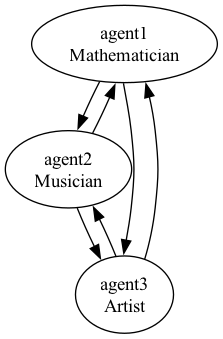

In [5]:
# g = Group(env="env.yaml",model_client=model_client)
g = Group(env=env,model_client=model_client) 
Image(g.draw_relations())

In [6]:
g.update_group_messages(Message(sender="user", action="talk", result="Can anyone help me with math? 2+2=?"))
g.update_group_messages(Message(sender="agent1", action="solve", result="2+2=4"))
g.update_group_messages(Message(sender="user", action="talk", result="Can anyone help me with music?"))

In [7]:
# %%timeit -n 10 -r 5
# res = g.handoff(next_speaker_select_mode="auto",model="gpt-4o-mini",include_current=True)
# # 1.07 s ± 202 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)
# %%timeit -n 10 -r 5
# res = g.handoff(next_speaker_select_mode="auto2",model="gpt-4o-mini",include_current=True)
# # 830 ms ± 113 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [8]:
# Do handoff
res = g.handoff(next_speaker_select_mode="auto2",model="gpt-4o-mini",include_current=True)

# Print the group message protocol instance
print('-'*50)
print("Below Is The Group Message Protocol Instance")
print('-'*50)
print(json.dumps(asdict(res), indent=4))
print('-'*50)
print("Below Message Send To `{}` who is {}".format(res.next_agent,g.members_map[res.next_agent].role))
print('-'*50)
print(g.build_send_message(res,cut_off=2))

--------------------------------------------------
Below Is The Group Message Protocol Instance
--------------------------------------------------
{
    "group_id": "4212012d-47a1-4ca6-a2ba-66333555fbd2",
    "env": {
        "description": "This is a test environment",
        "members": [
            {
                "name": "agent1",
                "role": "Mathematician",
                "description": "Transfer to me if you need help with math."
            },
            {
                "name": "agent2",
                "role": "Musician",
                "description": "Transfer to me if you need help with music."
            },
            {
                "name": "agent3",
                "role": "Artist",
                "description": "Transfer to me if you need help with art."
            }
        ],
        "relationships": {
            "agent1": [
                "agent2",
                "agent3"
            ],
            "agent2": [
                "agent1",
   

## Self Defined Relation

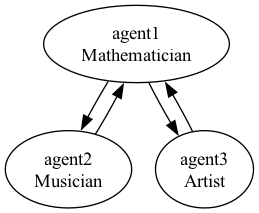

In [9]:
model_client = OpenAI()

env_with_relation = Env(
    description="This is a test environment",
    members=[
        Member(name="agent1", role="Mathematician", description="Transfer to me if you need help with math."),
        Member(name="agent2", role="Musician", description="Transfer to me if you need help with music."),
        Member(name="agent3", role="Artist", description="Transfer to me if you need help with art."),
    ],
    relationships={"agent1":["agent2","agent3"],"agent2":["agent1"],"agent3":["agent1"]}
)

example_g = Group(env=env_with_relation,model_client=model_client)
Image(example_g.draw_relations())